In [7]:
import yaml
import json
from pathlib import Path
import pandas as pd
import torch

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/cifar10/logs/decomposed")

In [8]:
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")

number of folders: 125


In [143]:
from datetime import datetime

dts = [datetime.fromtimestamp(int(x)) for x in folders]
print(max(dts))
print(min(dts))

2491-04-14 20:23:52
2022-02-16 13:31:57


In [144]:
# after = datetime(2022,2,14,19,0,0,0)
# before = datetime(2022,2,15,8,0,0,0)
# timestamps = []
# for ts, dt in ts_dts:
#     if dt > after and dt < before:
#         timestamps.append(ts)

In [145]:
paths = []
for folder in folders:
    found_decomp = False
    found_results = False
    for subfolder in os.listdir(logdir / folder):
        if 'lr' in subfolder:
            # found_decomp = True
            # break
            if (logdir / folder / subfolder / "results.json").exists():
                paths.append( logdir / folder / subfolder )
    # if not found_decomp or not found_results:
    #     folders.remove(folder)
print(len(paths))

120


In [183]:
# baseline

baseline_path = Path("/bigdata/f_mnist/logs/baselines/1644945876/rn18_18_dNone_256_adam_l0.001_g0.1_sTrue")
baseline_model = torch.load(baseline_path / "cnn_best.pth")

In [186]:
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)

In [187]:
baseline_result

{'best_epoch': 171,
 'best_train_acc': 0.9989454545454546,
 'best_valid_acc': 0.9568,
 'best_valid_loss': 0.001409929971396923,
 'test_acc': 0.944,
 'test_loss': 0.0016882505266927182,
 'n_param': 11172810,
 'model_name': 'rn18_18_dNone_256_adam_l0.001_g0.1_sTrue'}

In [147]:
def paths_to_results(paths):
    """Returns a pandas DataFrame with results"""
    results = []
    for path in paths:
        with open(path/'results.json') as json_file:
            result = json.load(json_file)
        results.append(result)
    
    keys = set()
    for result in results:
        keys = keys.union( set(result.keys()) )
    
    blank = {k:[] for k in keys}
    
    df = pd.DataFrame(blank) #.append(results[1], ignore_index=True)

    for result in results:
        df = df.append(result, ignore_index=True)
        
    df['compression'] = df['n_param_fact']/df['n_param'][0]
    df.compression[0] = 1.0
    
    
    return df

In [148]:
import torch
import tensorly as tl
tl.set_backend('pytorch')
from tddl.factorizations import number_layers
from tddl.factorizations import listify_numbered_layers

def relative_error(pre_weight, dec_weight):
    with torch.no_grad():
        return tl.norm(pre_weight-dec_weight)/tl.norm(pre_weight)

def process_factorized_network(model, fact_model, layer_nrs, first_layer_nr=0):

    pretrained_numbered_layers = number_layers(model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers, 
        layer_nrs=layer_nrs
    )

    decomposed_numbered_layers_resnet18 = number_layers(fact_model)
    decomposed_conv_layers_resnet18 = listify_numbered_layers(
        decomposed_numbered_layers_resnet18, 
        layer_nrs=layer_nrs
    )

    errors_conv_resnet18 = {
        'name': [],
        'nr': [],
        'error': [],
    }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers_resnet18):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        print(name)
        nr = pre[1]
        print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        
        errors_conv_resnet18['name'].append(name)
        errors_conv_resnet18['nr'].append(nr)
        errors_conv_resnet18['error'].append(float(error))

    df_errors = pd.DataFrame(data=errors_conv_resnet18)
    if first_layer_nr is not None:
        df_errors.name.iloc[first_layer_nr] = 'in'
    df_errors.set_index('nr', inplace=True)
    grouped_errors = df_errors.groupby(by='name')
    grouped_errors['error'].plot(legend=True, style=".-", ylabel='Relative Error', xlabel='Layer Number')

In [149]:
# b = True
# for path in paths:
#     timestamp = Path(path).parent
#     config_path = logdir / timestamp / "config.yml"
#     config_data = yaml.load(config_path.read_text(), Loader=yaml.Loader)
#     config_baseline_path = Path(config_data['baseline_path'])
#     if b:
#         print(config_baseline_path)
#         print(baseline_path)
#         print(10*"=")
#         b = False
#     if config_baseline_path != baseline_path:
#         print(config_baseline_path)
#         print(baseline_path)
#         print(10*"=")

In [150]:
# calc approximation error
# store in approx_error.json, next to results.json
import yaml

for path in paths:
    print(path)
    timestamp = Path(path).parent
    config_path = logdir / timestamp / "config.yml"
    config_data = yaml.load(config_path.read_text(), Loader=yaml.Loader)
    layers = config_data['layers']

    fact_model = torch.load(path / 'model_after_fact.pth')

    pretrained_numbered_layers = number_layers(baseline_model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers,
        layer_nrs=layers,
    )

    decomposed_numbered_layers = number_layers(fact_model)
    decomposed_conv_layers = listify_numbered_layers(
        decomposed_numbered_layers,
        layer_nrs=layers,
    )

    with open(path / 'results.json') as json_file:
        result = json.load(json_file)

    with open(path / 'results_before_training.json') as json_file:
        result_before_training = json.load(json_file)

    errors_conv = {
            'name': [],
            'nr': [],
            'error': [],
            'layers': layers,
            'factorization': config_data['factorization'],
            'rank': config_data['rank'],
            'valid_acc': result['best_valid_acc'],
            'valid_acc_before_ft': result_before_training['valid_acc'],
            'n_param_fact': result['n_param_fact'],
            'test_acc': result['test_acc'],
            'lr': config_data['lr'],
            'optimizer': config_data['optimizer'],
        }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        # print(name)
        nr = pre[1]
        # print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        # print(error)
        
        errors_conv['name'].append(name)
        errors_conv['nr'].append(nr)
        errors_conv['error'].append(float(error))

    errors_path = logdir / path / 'results_approximation_error.json'
    with open(errors_path, 'w') as f:
        json.dump(errors_conv, f)

/bigdata/f_mnist/logs/decomposed_adam/1645047993/rn18-lr-[38]-tucker-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645048960/rn18-lr-[44]-cp-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645017615/rn18-lr-[28]-tucker-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645030534/rn18-lr-[28]-tucker-0.75-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645023670/rn18-lr-[15]-tucker-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645048639/rn18-lr-[41]-tucker-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645047643/rn18-lr-[38]-cp-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645037585/rn18-lr-[28]-tucker-0.9-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645031732/rn18-lr-[28]-tucker-0.9-dTrue-iNone_bn_256_sgd

In [101]:
results = []
for path in paths:
    with open(path / 'results_approximation_error.json') as json_file:
        result = json.load(json_file)
    print(result)
    for k,v in result.items():
        result[k] = v[0] if type(v) == list else v
    results.append(result)

{'name': ['conv2'], 'nr': [38], 'error': [0.4174124002456665], 'layers': [38], 'factorization': 'tucker', 'rank': 0.5, 'valid_acc': 0.9566, 'valid_acc_before_ft': 0.956, 'n_param_fact': 10878589, 'test_acc': 0.9445, 'lr': 1e-05, 'optimizer': 'adam'}
{'name': ['conv1'], 'nr': [44], 'error': [0.3200853765010834], 'layers': [44], 'factorization': 'cp', 'rank': 0.5, 'valid_acc': 0.9566, 'valid_acc_before_ft': 0.9566, 'n_param_fact': 10878297, 'test_acc': 0.9448, 'lr': 1e-05, 'optimizer': 'adam'}
{'name': ['conv1'], 'nr': [28], 'error': [0.5388582944869995], 'layers': [28], 'factorization': 'tucker', 'rank': '0.50', 'valid_acc': 0.9528, 'valid_acc_before_ft': 0.9512, 'n_param_fact': 11098445, 'test_acc': 0.9451, 'lr': 1e-05, 'optimizer': 'adam'}
{'name': ['conv1'], 'nr': [28], 'error': [0.39221373200416565], 'layers': [28], 'factorization': 'tucker', 'rank': '0.75', 'valid_acc': 0.955, 'valid_acc_before_ft': 0.9534, 'n_param_fact': 11136896, 'test_acc': 0.9453, 'lr': 1e-05, 'optimizer': 'ad

In [158]:
df = pd.DataFrame(results)
df.head()


,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer
0,conv2,38,0.417412,38,tucker,0.5,0.9566,0.9560,10878589,0.9445,0.00001,adam
1,conv1,44,0.320085,44,cp,0.5,0.9566,0.9566,10878297,0.9448,0.00001,adam
2,conv1,28,0.538858,28,tucker,0.50,0.9528,0.9512,11098445,0.9451,0.00001,adam
3,conv1,28,0.392214,28,tucker,0.75,0.9550,0.9534,11136896,0.9453,0.00001,adam
4,conv2,15,0.508273,15,tucker,0.5,0.9538,0.9532,11154645,0.9453,0.00001,adam


In [159]:
df['rank'] = df['rank'].astype(float, copy=False)
# df['rank'].apply(float)
df['rank'].unique()
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df['fact_layers'] = df['factorization'] + '-' + df['layers'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,fact_rank,fact_layers
0,conv2,38,0.417412,38,tucker,0.50,0.9566,0.9560,10878589,0.9445,0.00001,adam,tucker-0.5,tucker-38
1,conv1,44,0.320085,44,cp,0.50,0.9566,0.9566,10878297,0.9448,0.00001,adam,cp-0.5,cp-44
2,conv1,28,0.538858,28,tucker,0.50,0.9528,0.9512,11098445,0.9451,0.00001,adam,tucker-0.5,tucker-28
3,conv1,28,0.392214,28,tucker,0.75,0.9550,0.9534,11136896,0.9453,0.00001,adam,tucker-0.75,tucker-28
4,conv2,15,0.508273,15,tucker,0.50,0.9538,0.9532,11154645,0.9453,0.00001,adam,tucker-0.5,tucker-15


In [160]:
df_rank = df.set_index('rank', inplace=False)

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: error, dtype: object

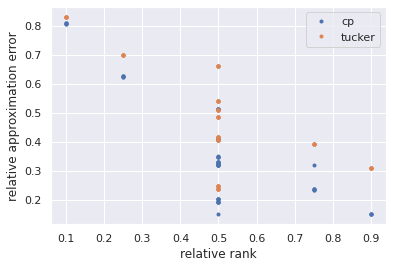

In [161]:
grouped_df = df_rank.groupby('factorization')
ax = grouped_df['error'].plot(legend=True, style=".", ylabel='relative approximation error', xlabel='relative rank')

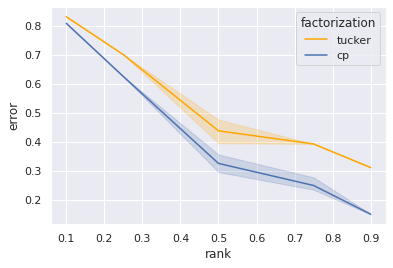

In [162]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)
# Plot the responses for different events and regions
ax = sns.lineplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

<AxesSubplot:xlabel='rank', ylabel='error'>

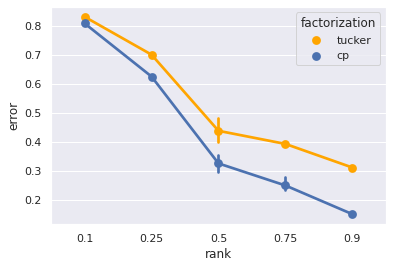

In [163]:
sns.pointplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

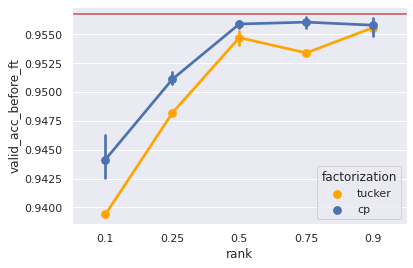

In [199]:
ax = sns.pointplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')

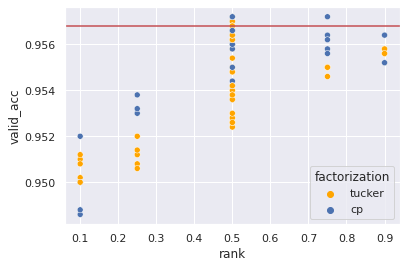

In [202]:
ax = sns.scatterplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')

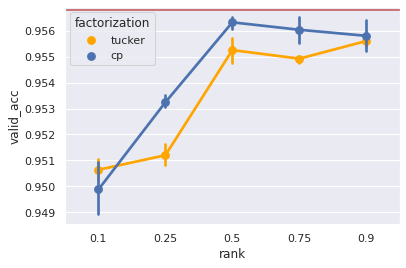

In [198]:
ax = sns.pointplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')

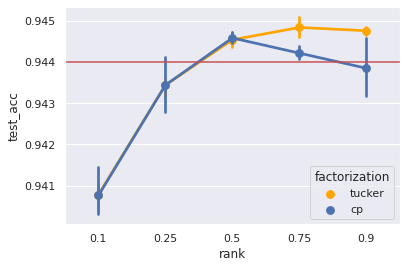

In [200]:
ax = sns.pointplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['test_acc'], color='r')

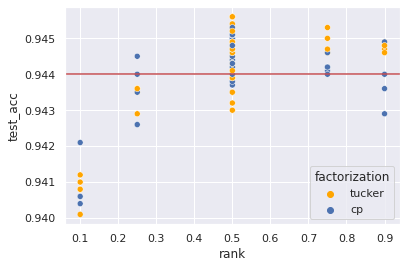

In [204]:
ax = sns.scatterplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['test_acc'], color='r')

In [201]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['rank'].plot(legend=True, style=".-", ylabel='relative rank', xlabel='relative approximation error')

TypeError: no numeric data to plot

In [111]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

AttributeError: 'FacetGrid' object has no attribute 'axhline'

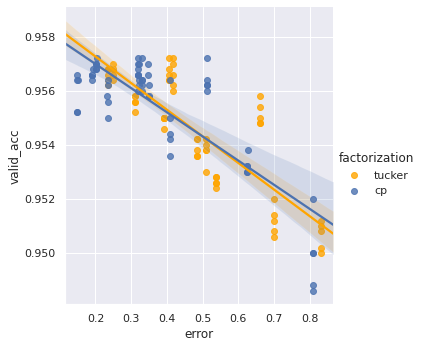

In [196]:
g = sns.lmplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    # y_jitter=.02, 
    # logistic=True, 
    # style="rank",
    truncate=False, palette=['orange', 'b'], 
)
g = g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')


In [26]:
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,fact_rank
0,conv2,38,0.417443,38,tucker,0.50,0.9566,0.9560,10878589,0.9445,0.00001,adam,tucker-0.5
1,conv1,44,0.322214,44,cp,0.50,0.9566,0.9566,10878297,0.9448,0.00001,adam,cp-0.5
2,conv1,28,0.538981,28,tucker,0.50,0.9528,0.9512,11098445,0.9451,0.00001,adam,tucker-0.5
3,conv1,28,0.392504,28,tucker,0.75,0.9550,0.9534,11136896,0.9453,0.00001,adam,tucker-0.75
4,conv2,15,0.508425,15,tucker,0.50,0.9538,0.9532,11154645,0.9453,0.00001,adam,tucker-0.5


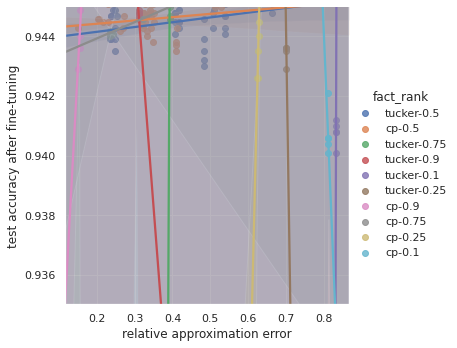

In [27]:
g = sns.lmplot(x="error", y="test_acc", 
   hue="fact_rank", 
   data=df,
   truncate=False, 
   # palette=['orange','b'],
)
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
g.set(ylim=(0.935, 0.945))

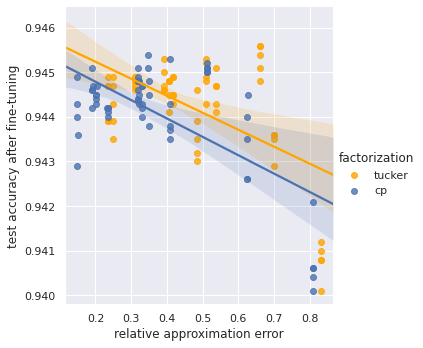

In [165]:
g = sns.lmplot(x="error", y="test_acc", 
   hue="factorization", 
   data=df,
   # logistic=True,
   truncate=False, 
   palette=['orange','b'],
)
g = g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: valid_acc_before_ft, dtype: object

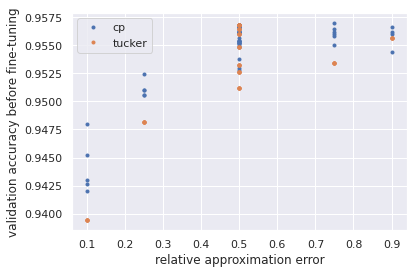

In [115]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

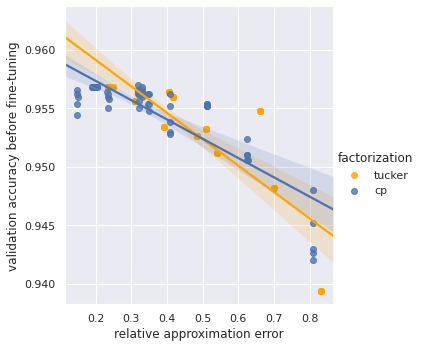

In [166]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

In [167]:
df_layers = pd.DataFrame(results)
df_layers['rank'] = df_layers['rank'].astype(float, copy=False)
df_layers = df_layers.loc[df_layers['rank'] == 0.5]
df_layers

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer
0,conv2,38,0.417412,38,tucker,0.5,0.9566,0.9560,10878589,0.9445,0.00001,adam
1,conv1,44,0.320085,44,cp,0.5,0.9566,0.9566,10878297,0.9448,0.00001,adam
2,conv1,28,0.538858,28,tucker,0.5,0.9528,0.9512,11098445,0.9451,0.00001,adam
4,conv2,15,0.508273,15,tucker,0.5,0.9538,0.9532,11154645,0.9453,0.00001,adam
5,0,41,0.661809,41,tucker,0.5,0.9548,0.9548,11156556,0.9456,0.00001,adam
...,...,...,...,...,...,...,...,...,...,...,...,...
114,conv1,60,0.248301,60,tucker,0.5,0.9564,0.9568,9995872,0.9449,0.00001,adam
115,conv1,28,0.408988,28,cp,0.5,0.9564,0.9552,11099257,0.9443,0.00001,adam
117,conv1,44,0.405947,44,tucker,0.5,0.9564,0.9564,10878589,0.9441,0.00001,adam
118,conv1,44,0.318756,44,cp,0.5,0.9566,0.9564,10878297,0.9448,0.00001,adam


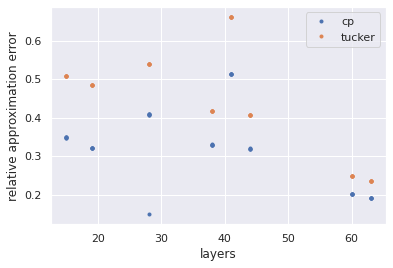

In [168]:
df_layers_idx = df_layers.set_index('layers', inplace=False)
grouped_df_layers = df_layers_idx.groupby('factorization')
ax = grouped_df_layers['error'].plot(legend=True, style=".", ylabel='relative approximation error')

In [170]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('layers', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['error'].plot(legend=True, style=".-", ylabel='relative approximation error')

# ax = grouped_df_layers['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

In [172]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('error', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

<AxesSubplot:xlabel='layers', ylabel='error'>

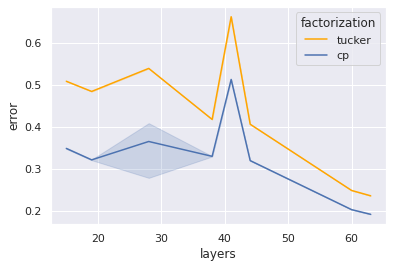

In [173]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)

# Plot the responses for different events and regions
sns.lineplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             )

<AxesSubplot:xlabel='layers', ylabel='error'>

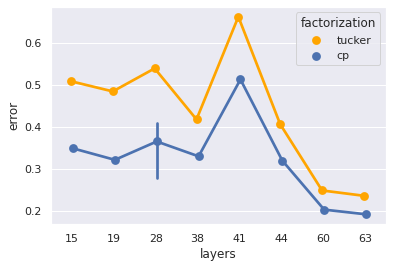

In [174]:
sns.pointplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True
             )

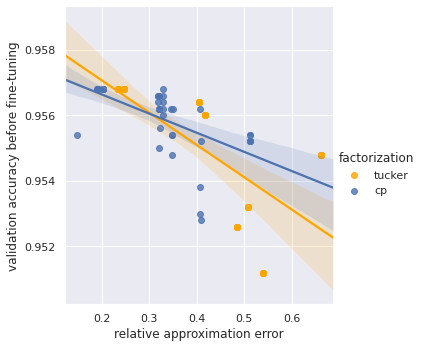

In [175]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

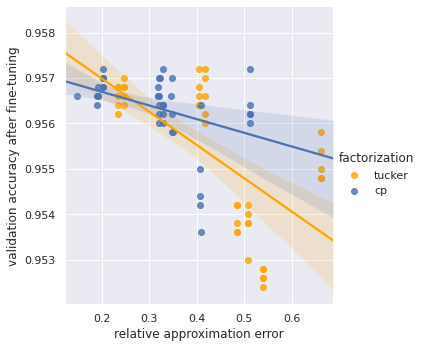

In [179]:
g = sns.lmplot(x="error", y="valid_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')

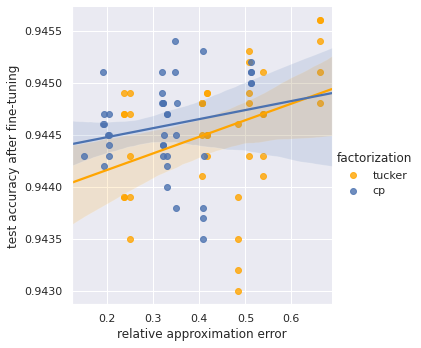

In [180]:
g = sns.lmplot(x="error", y="test_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

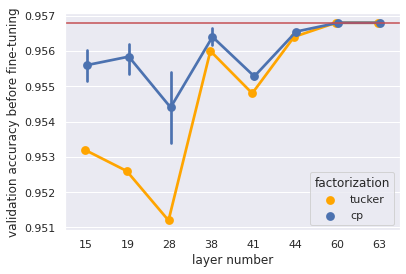

In [193]:
ax = sns.pointplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax = ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')

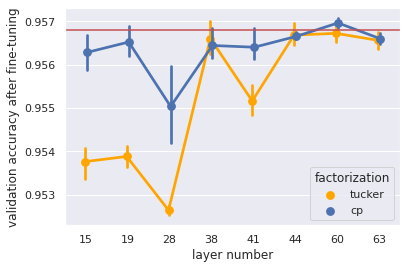

In [194]:
ax = sns.pointplot(x="layers", y="valid_acc",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax = ax.set(xlabel='layer number', ylabel='validation accuracy after fine-tuning')


[Text(0.5, 0, 'layer number'), Text(0, 0.5, 'test accuracy after fine-tuning')]

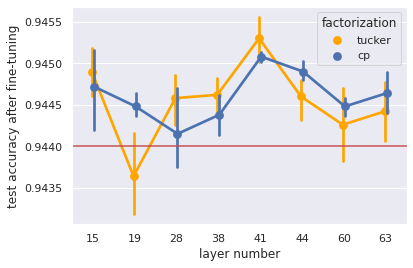

In [195]:
ax = sns.pointplot(x="layers", y="test_acc",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='layer number', ylabel='test accuracy after fine-tuning')

In [132]:
df.factorization.isna()

0      False
1      False
2      False
3      False
4      False
       ...  
115    False
116    False
117    False
118    False
119    False
Name: factorization, Length: 120, dtype: bool

In [136]:
df[df.error.isnull()]

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,fact_rank,fact_layers


In [157]:
df_layer_rank = df.groupby(['factorization','layers','rank'])
df_std = df_layer_rank[['valid_acc','test_acc']].std()

print(df_std.to_latex())

\begin{tabular}{lllrr}
\toprule
       &    &      &  valid\_acc &  test\_acc \\
factorization & layers & rank &            &           \\
\midrule
cp & 15 & 0.50 &   0.000522 &  0.000614 \\
       & 19 & 0.50 &   0.000460 &  0.000192 \\
       & 28 & 0.10 &   0.001354 &  0.000777 \\
       &    & 0.25 &   0.000329 &  0.000844 \\
       &    & 0.50 &   0.001223 &  0.000650 \\
       &    & 0.75 &   0.000548 &  0.000089 \\
       &    & 0.90 &   0.000693 &  0.000835 \\
       & 38 & 0.50 &   0.000456 &  0.000311 \\
       & 41 & 0.50 &   0.000469 &  0.000084 \\
       & 44 & 0.50 &   0.000100 &  0.000141 \\
       &    & 0.75 &        NaN &       NaN \\
       & 60 & 0.50 &   0.000167 &  0.000148 \\
       & 63 & 0.50 &   0.000141 &  0.000321 \\
tucker & 15 & 0.50 &   0.000456 &  0.000394 \\
       & 19 & 0.50 &   0.000303 &  0.000635 \\
       & 28 & 0.10 &   0.000518 &  0.000415 \\
       &    & 0.25 &   0.000548 &  0.000305 \\
       &    & 0.50 &   0.000167 &  0.000390 \\
       &  

In [154]:
!pwd

/home/jetzeschuurman/gitProjects/phd/tddl/notebooks/results


In [156]:
df.to_json("/home/jetzeschuurman/gitProjects/phd/tddl/artifacts/f_mnist/std_adam.json")